In [11]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [12]:
!kaggle datasets download -d kasikrit/308-456-dogs-vs-cats-dataset

Dataset URL: https://www.kaggle.com/datasets/kasikrit/308-456-dogs-vs-cats-dataset
License(s): unknown
308-456-dogs-vs-cats-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [13]:
# dataset link
# https://www.kaggle.com/datasets/kasikrit/308-456-dogs-vs-cats-dataset

In [14]:
import zipfile
zip_ref=zipfile.ZipFile('/content/308-456-dogs-vs-cats-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [15]:
import tensorflow
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as img

In [16]:
train_data = "/content/dataset_dogs_vs_cats/train"
validation_data = '/content/dataset_dogs_vs_cats/valid'

In [17]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'

)

In [18]:
validation_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [19]:
train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary'
)

Found 18697 images belonging to 2 classes.


In [20]:
validation_generator = validation_datagen.flow_from_directory(
    validation_data,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary'
)

Found 6303 images belonging to 2 classes.


In [21]:
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers

base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

83683744/83683744 [==============================] - 0s 0us/step


In [22]:
import os

# Create the directory if it doesn't exist
os.makedirs("/content/Colab_Notebooks/", exist_ok=True)

In [23]:
model = Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(Dense(256,activation = 'relu'))
model.add(Dense(256,activation = 'relu'))
model.add(Dense(256,activation = 'relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(1, activation = 'sigmoid'))


model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')

# Define callbacks
checkpoint = ModelCheckpoint("/content/Colab_Notebooks/dogVsCatTL_model.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0.001,
                          patience=5,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=3,
                              min_lr=0.00001,
                              verbose=1)


In [24]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    callbacks=[checkpoint, earlystop, reduce_lr]
)

Epoch 1/15
584/584 [==============================] - ETA: 0s - loss: 0.0898 - accuracy: 0.9651
Epoch 1: val_loss improved from inf to 0.04051, saving model to /content/Colab_Notebooks/dogVsCatTL_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


584/584 [==============================] - 320s 530ms/step - loss: 0.0898 - accuracy: 0.9651 - val_loss: 0.0405 - val_accuracy: 0.9861 - lr: 0.0010
Epoch 2/15
584/584 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9724
Epoch 2: val_loss did not improve from 0.04051
584/584 [==============================] - 306s 525ms/step - loss: 0.0723 - accuracy: 0.9724 - val_loss: 0.0464 - val_accuracy: 0.9871 - lr: 0.0010
Epoch 3/15
584/584 [==============================] - ETA: 0s - loss: 0.0729 - accuracy: 0.9717
Epoch 3: val_loss improved from 0.04051 to 0.03301, saving model to /content/Colab_Notebooks/dogVsCatTL_model.h5
584/584 [==============================] - 295s 505ms/step - loss: 0.0729 - accuracy: 0.9717 - val_loss: 0.0330 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 4/15
584/584 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 0.9754
Epoch 4: val_loss did not improve from 0.03301
584/584 [==============================] - 297s 508ms/step - 

In [25]:
model.save('dogVsCat_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


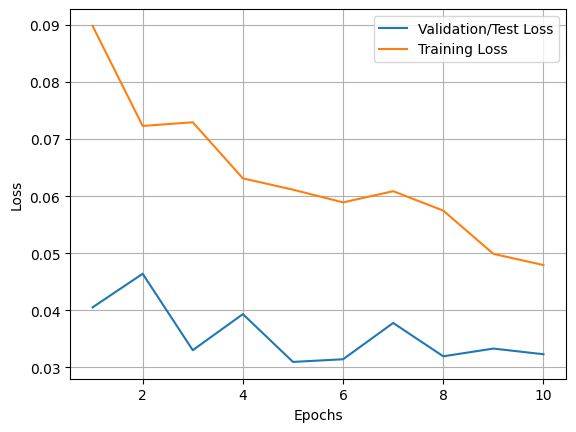

In [26]:
# Plotting our loss charts
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

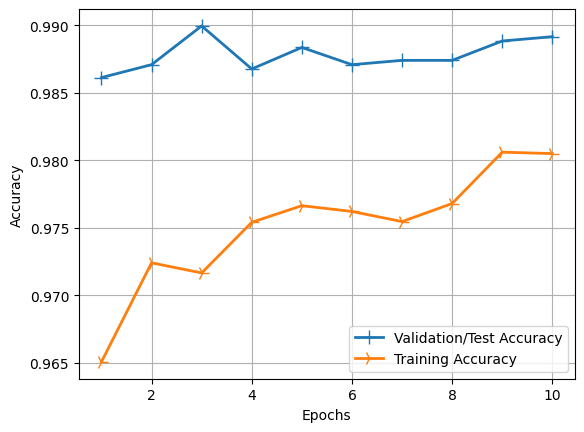

In [27]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

random image number:  161
(32, 224, 224, 3) (32,)
[1. 1. 0. 1. 0. 1. 1. 1. 1. 1.]


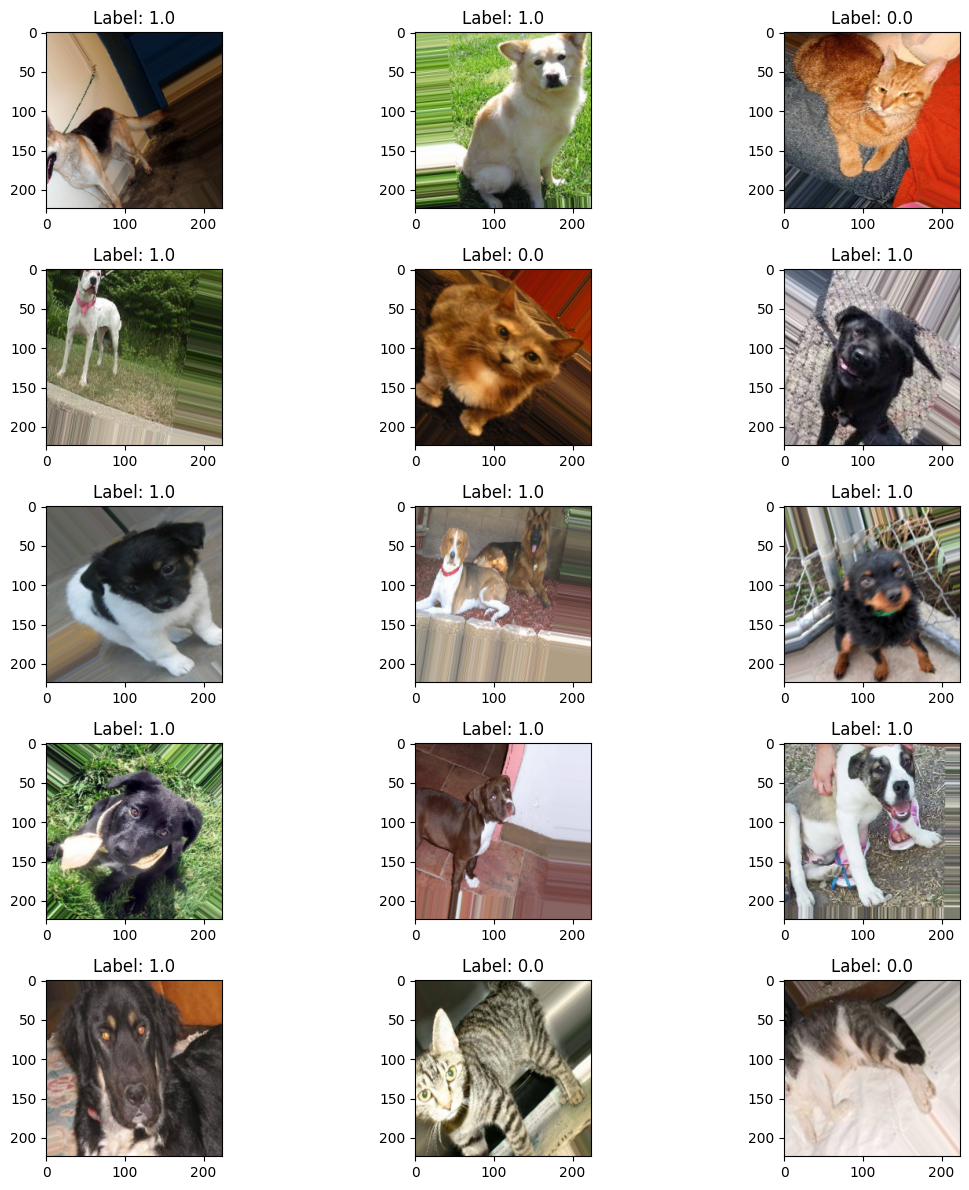

In [28]:
import random
image_number = random.randint(0, len(train_generator))
print('random image number: ', image_number)
X_batch, y_batch = train_generator.__getitem__(image_number) #dudder method
print(X_batch.shape, y_batch.shape)
print(y_batch[:10])

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    image = X_batch[i]
    plt.imshow(image)
    plt.title("Label: " + str(y_batch[i]))
plt.tight_layout()
plt.show()

1/1 [==============================] - 1s 1s/step
[[0.6885087]]


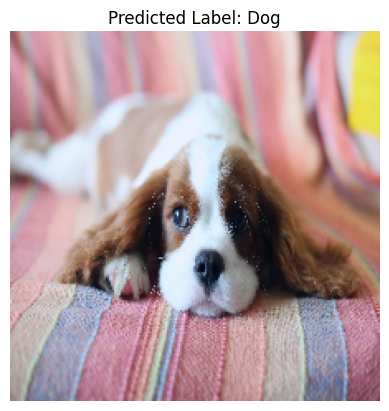

In [33]:
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import load_model
import matplotlib.pyplot as plt

# load and prepare the image
def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(224, 224))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, 224, 224, 3)
    # center pixel data
    img = img.astype('float32')
    img = img - [123.68, 116.779, 103.939]
    return img

# load an image and predict the class
def run_example():
    # load the image
    img = load_image('/content/izabelly-marques-Ytp_K5bwa0Q-unsplash.jpg')
    # load model
    model = load_model('/content/Colab_Notebooks/dogVsCatTL_model.h5')
    # predict the class
    result = model.predict(img)
    print (result)

    # Convert the predicted probability to a class label
    if result[0] > 0.5:
        label = 'Dog'
    else:
        label = 'Cat'

    # Convert the array back to image
    img = array_to_img(img[0])

    # Display the image
    plt.imshow(img)
    plt.title('Predicted Label: ' + label)
    plt.axis('off')
    plt.show()

# entry point, run the example
run_example()